# 7장. 자연어 처리를 위한 순환 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch07/07-rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

## RNN으로 텍스트 분류기 만들기

In [1]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [4]:
vocab_size = 20000
embedding_dim = 64
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [7]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,349,169
Trainable params: 1,349,169
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 37s 48ms/step - loss: 0.6877 - accuracy: 0.5596 - val_loss: 0.6830 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 35s 49ms/step - loss: 0.6830 - accuracy: 0.5596 - val_loss: 0.6787 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 35s 49ms/step - loss: 0.6794 - accuracy: 0.5596 - val_loss: 0.6747 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 35s 49ms/step - loss: 0.6733 - accuracy: 0.5596 - val_loss: 0.6665 - val_accuracy: 0.5702
Epoch 5/30
719/719 [==============================] - 36s 50ms/step - loss: 0.6616 - accuracy: 0.5708 - val_loss: 0.6524 - val_accuracy: 0.6093
Epoch 6/30
719/719 [==============================] - 36s 50ms/step - loss: 0.6428 - accuracy: 0.6414 - val_loss: 0.6327 - val_accuracy: 0.6697
Epoch 7/30
719/719 [==============================] - 36s 50ms/step - loss: 0.6186 - accuracy: 0.6894 - val_loss: 0.6112 - val_accuracy:

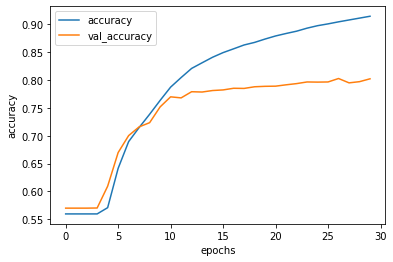

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

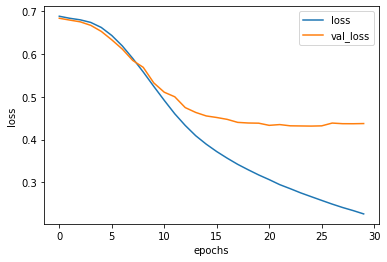

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 스태킹 LSTM

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,447,985
Trainable params: 1,447,985
No

In [15]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 72s 95ms/step - loss: 0.6895 - accuracy: 0.5515 - val_loss: 0.6835 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6836 - accuracy: 0.5596 - val_loss: 0.6799 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6804 - accuracy: 0.5596 - val_loss: 0.6754 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6688 - accuracy: 0.5751 - val_loss: 0.6516 - val_accuracy: 0.6403
Epoch 5/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6093 - accuracy: 0.6903 - val_loss: 0.5665 - val_accuracy: 0.7188
Epoch 6/30
719/719 [==============================] - 67s 93ms/step - loss: 0.4818 - accuracy: 0.7720 - val_loss: 0.4880 - val_accuracy: 0.7681
Epoch 7/30
719/719 [==============================] - 67s 93ms/step - loss: 0.4081 - accuracy: 0.8183 - val_loss: 0.4746 - val_accuracy:

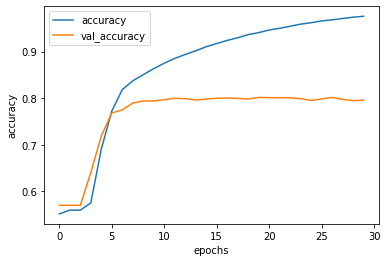

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

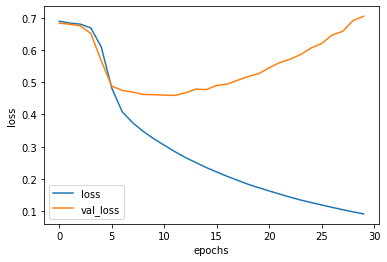

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 스태킹 LSTM 최적화하기

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [19]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 71s 93ms/step - loss: 0.6894 - accuracy: 0.5496 - val_loss: 0.6836 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 66s 92ms/step - loss: 0.6838 - accuracy: 0.5596 - val_loss: 0.6800 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6812 - accuracy: 0.5596 - val_loss: 0.6769 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6761 - accuracy: 0.5597 - val_loss: 0.6693 - val_accuracy: 0.5705
Epoch 5/30
719/719 [==============================] - 67s 93ms/step - loss: 0.6561 - accuracy: 0.6095 - val_loss: 0.6330 - val_accuracy: 0.6705
Epoch 6/30
719/719 [==============================] - 67s 93ms/step - loss: 0.5928 - accuracy: 0.7082 - val_loss: 0.5572 - val_accuracy: 0.7201
Epoch 7/30
719/719 [==============================] - 67s 93ms/step - loss: 0.4791 - accuracy: 0.7757 - val_loss: 0.5024 - val_accuracy:

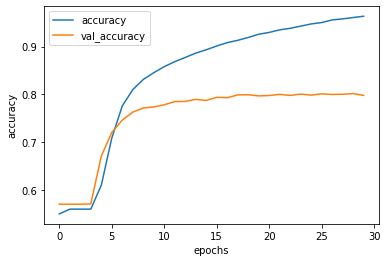

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

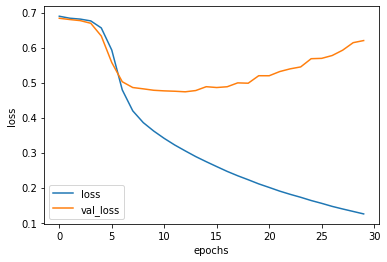

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 드롭아웃 사용하기

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        embedding_dim, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,
                                                       dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.000008, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,metrics=['accuracy'])

In [23]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 74s 98ms/step - loss: 0.6888 - accuracy: 0.5545 - val_loss: 0.6832 - val_accuracy: 0.5700
Epoch 2/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6840 - accuracy: 0.5596 - val_loss: 0.6805 - val_accuracy: 0.5700
Epoch 3/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6819 - accuracy: 0.5596 - val_loss: 0.6777 - val_accuracy: 0.5700
Epoch 4/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6778 - accuracy: 0.5596 - val_loss: 0.6716 - val_accuracy: 0.5700
Epoch 5/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6654 - accuracy: 0.5840 - val_loss: 0.6525 - val_accuracy: 0.6562
Epoch 6/30
719/719 [==============================] - 69s 96ms/step - loss: 0.6330 - accuracy: 0.6681 - val_loss: 0.6184 - val_accuracy: 0.6805
Epoch 7/30
719/719 [==============================] - 69s 97ms/step - loss: 0.5800 - accuracy: 0.7163 - val_loss: 0.5612 - val_accuracy:

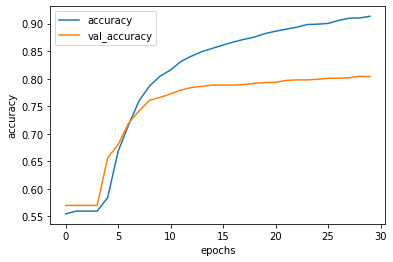

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

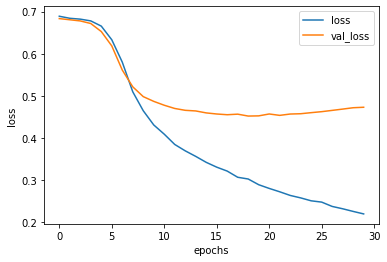

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## RNN에 사전 훈련된 임베딩 사용하기

In [26]:
!wget https://bit.ly/3i9taLA -O glove.zip

--2022-03-16 18:15:42--  https://bit.ly/3i9taLA
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip [following]
--2022-03-16 18:15:43--  https://tensorflowkorea.files.wordpress.com/2022/03/glove.twitter.27b.25d.txt.zip
Resolving tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)... 192.0.72.18, 192.0.72.19
Connecting to tensorflowkorea.files.wordpress.com (tensorflowkorea.files.wordpress.com)|192.0.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109906941 (105M) [application/zip]
Saving to: ‘glove.zip’

glove.zip           100%[===================>] 104.81M  11.7MB/s    in 9.1s    

2022-03-16 18:15:52 (11.6 MB/s) - ‘glove.zip’ saved [109906941/109906941]



In [27]:
# GloVe 임베딩 압축 풀기
import os
import zipfile
local_zip = 'glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [28]:
glove_embeddings = dict()
f = open('glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [29]:
glove_embeddings['frog']

array([-1.2158  , -0.74924 ,  0.91941 ,  0.72985 , -0.12917 , -0.19555 ,
        1.2365  , -0.77196 ,  0.85161 ,  0.11922 ,  0.16816 ,  0.33334 ,
       -2.0845  , -0.53471 ,  0.013538,  0.18178 ,  1.2831  ,  0.089331,
        0.57264 ,  0.50694 ,  0.27134 ,  0.66504 ,  0.54097 , -0.58377 ,
        0.67097 ], dtype=float32)

In [30]:
vocab_size = 13200
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [31]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [32]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [33]:
xs=[]
ys=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
    xs.append(index)
    if glove_embeddings.get(word) is not None:
        total_y = total_y + 1
        ys.append(1)
    else:
        ys.append(0)
    cumulative_y.append(total_y / index)

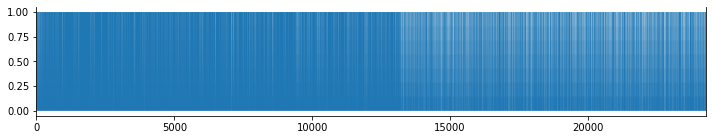

In [34]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)
plt.show()

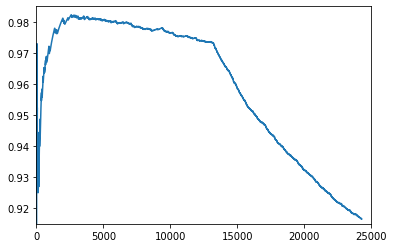

In [35]:
plt.plot(xs, cumulative_y)
plt.axis([0, 25000, .915, .985])
plt.show()

In [36]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [37]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [39]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 34s 41ms/step - loss: 0.6859 - accuracy: 0.5601 - val_loss: 0.6807 - val_accuracy: 0.5775
Epoch 2/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6764 - accuracy: 0.5888 - val_loss: 0.6718 - val_accuracy: 0.6083
Epoch 3/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6641 - accuracy: 0.6321 - val_loss: 0.6585 - val_accuracy: 0.6314
Epoch 4/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6476 - accuracy: 0.6484 - val_loss: 0.6440 - val_accuracy: 0.6500
Epoch 5/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6317 - accuracy: 0.6609 - val_loss: 0.6297 - val_accuracy: 0.6592
Epoch 6/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6184 - accuracy: 0.6716 - val_loss: 0.6187 - val_accuracy: 0.6657
Epoch 7/30
719/719 [==============================] - 29s 40ms/step - loss: 0.6083 - accuracy: 0.6783 - val_loss: 0.6104 - val_accuracy:

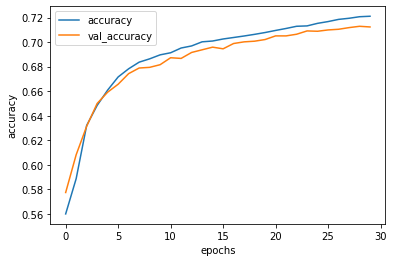

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

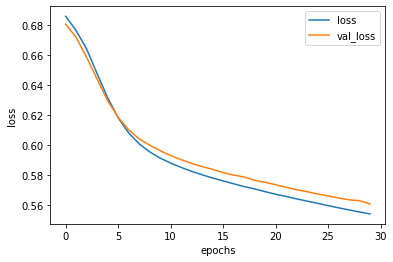

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.00001, 
                                beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

num_epochs = 150
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels))

Epoch 1/150
719/719 [==============================] - 34s 41ms/step - loss: 0.6956 - accuracy: 0.4804 - val_loss: 0.6912 - val_accuracy: 0.5530
Epoch 2/150
719/719 [==============================] - 29s 40ms/step - loss: 0.6878 - accuracy: 0.5720 - val_loss: 0.6848 - val_accuracy: 0.5813
Epoch 3/150
719/719 [==============================] - 29s 40ms/step - loss: 0.6802 - accuracy: 0.5918 - val_loss: 0.6760 - val_accuracy: 0.6029
Epoch 4/150
719/719 [==============================] - 28s 39ms/step - loss: 0.6691 - accuracy: 0.6159 - val_loss: 0.6643 - val_accuracy: 0.6163
Epoch 5/150
719/719 [==============================] - 29s 40ms/step - loss: 0.6546 - accuracy: 0.6383 - val_loss: 0.6499 - val_accuracy: 0.6420
Epoch 6/150
719/719 [==============================] - 29s 40ms/step - loss: 0.6385 - accuracy: 0.6521 - val_loss: 0.6360 - val_accuracy: 0.6460
Epoch 7/150
719/719 [==============================] - 29s 40ms/step - loss: 0.6243 - accuracy: 0.6606 - val_loss: 0.6248 - val_ac

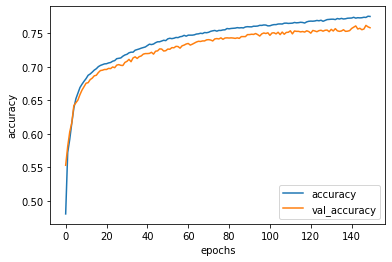

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

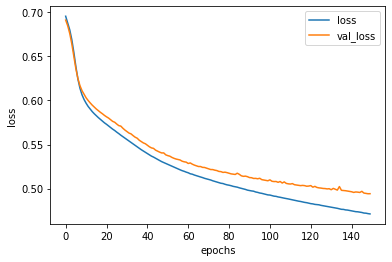

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [45]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
predictions = model.predict(padded)
print(predictions)

[[0.63429683]
 [0.12458932]
 [0.67115533]
 [0.65346825]]
